In [1]:
import numpy as np
from numpy.random import randn
import gzip
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import warnings
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号 

warnings.filterwarnings('ignore')

# 加载数据

In [2]:
class DataProcess:
    def __init__(self):
        dic = dict()
        for i in range(10):
            a = np.zeros(10)
            a[i] = 1
            dic[i] = a
        self.dic = dic
    def load_data(self,xtrain_dir='train-images-idx3-ubyte.gz', ytrain_dir='train-labels-idx1-ubyte.gz', xtest_dir='t10k-images-idx3-ubyte.gz', ytest_dir='t10k-labels-idx1-ubyte.gz'):
        dic = self.dic
        with gzip.open(xtrain_dir) as all_img:
            xtrain = all_img.read()
        with gzip.open(ytrain_dir) as all_img:
            ytrain = all_img.read()
        with gzip.open(xtest_dir) as all_img:
            xtest = all_img.read()
        with gzip.open(ytest_dir) as all_img:
            ytest = all_img.read()
        xtrainl, ytrainl, xtestl, ytestl = [],[],[],[]
        for i in tqdm(range(60000)):
            xtrainb = xtrain[16 + 784 * i:16 + 784 * (i + 1)]
            ytrainl.append(dic[ytrain[8 + i]])
            xtrainl.append([xtrainb[j] for j in range(784)])
        for i in tqdm(range(10000)):
            xtestb = xtest[16 + 784 * i:16 + 784 * (i + 1)]
            ytestl.append(dic[ytest[8 + i]])
            xtestl.append([xtestb[j] for j in range(784)])
        return np.asarray(xtrainl),np.asarray(ytrainl),np.asarray(xtestl),np.asarray(ytestl)

    def view_x(self, x):
        img = x.reshape(28,28)
        plt.imshow(img)
        plt.show()

In [3]:
dp = DataProcess()
xtrain_dir, ytrain_dir, xtest_dir, ytest_dir = 'train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz','t10k-labels-idx1-ubyte.gz'
xtrain, ytrain, xtest, ytest = dp.load_data(xtrain_dir, ytrain_dir, xtest_dir, ytest_dir)
# xtest,ytest, xvalid,yvalid = xtest[0:5000],ytest[0:5000],xtest[5000:10000], ytest[5000:10000]
# print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape,xvalid.shape, yvalid.shape)
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 48478.58it/s]


(60000, 784) (60000, 10) (10000, 784) (10000, 10)


# 训练

In [4]:
def predict(x,w1,w2):
    h = 1.0 / (1.0 + np.exp(-x@w1))
    y_pred = h@w2
    return y_pred

def get_loss(y, y_pred):
    loss = np.square(y_pred - y).sum()
    return loss/len(y)

def accuracy(ytrue, ypre):
    ytrue = np.argmax(ytrue,1)
    ypre = np.argmax(ypre,1)
    compare = (ytrue == ypre)
    return round(sum(compare)/len(compare),3)

采用mini-batch-SGD的随机梯度下降方法

In [5]:
N,Din,H,Dout = 60000, 784, 100, 10
N_valid = 5000
lambda3 = 1e-3
w1, w2 = randn(Din, H), randn(H, Dout) # 使用随机初始化参数
# weights= np.load('weights.npz')
# w1, w2 = weights['arr_0'], weights['arr_1'] # 使用预训练参数继续训练
lambda1 = lambda2 = lambda3 # 正则化参数
batch_size = 30
# Epoch = 100000
np.random.seed(2023) # 设置随机数种子
lr0 = lr1 = 1e-4
lr2 = lr1 * 10
beta = 0.9999999 # 学习率下降策略衰减因子
t_list = []
val_loss_list = []
train_loss_list = []
accuracy_list = []
mini_val_loss = float('inf')
# for t in range(Epoch):
t = 0
t_star = 0
w1_star =None
w2_star = None
while 1:
    id = np.random.randint(N - batch_size)
    x, y = xtrain[id:id + batch_size], ytrain[id: id+ batch_size]
    h = 1.0 / (1.0 + np.exp(-x@w1))
    y_pred = h@w2
    loss = np.square(y_pred - y).sum()
#     if (t+1)%20000 == 0:
    
    if (t+1)%20000 == 0:
        yval_pre = predict(xtest, w1, w2)
        yval_loss = get_loss(ytest, yval_pre)
        ytrain_pre = predict(xtrain, w1, w2)
        ytrain_loss = get_loss(ytrain,ytrain_pre)
        accuracy_value =  accuracy(ytest, yval_pre)
        t_list.append(t)
        val_loss_list.append(yval_loss)
        train_loss_list.append(ytrain_loss)
        accuracy_list.append(accuracy_value)
        if yval_loss < mini_val_loss:
            mini_val_loss = yval_loss
            t_star = t
            w1_star = w1
            w2_star = w2
        print(f'Epoch {int((t+1)/20000)} 0 train loss:',round(ytrain_loss, 2), 'test loss:',round(yval_loss, 2), 'accuracy:',accuracy_value)
        if t - t_star > t_star:
            break
    dy_pred = 2.0 * (y_pred - y)
    dw2 = h.T.dot(dy_pred) + lambda2 * w2 # L2正则化
    dh = dy_pred.dot(w2.T)
    dw1 = x.T.dot(dh * h * (1-h)) + lambda1 * w1 # L2正则化
    w1 -= lr1* dw1
    w2 -= lr1* dw2
    if lr1 < lr2:
        lr1 = lr1 ** beta
    t += 1
print('验证集最小损失：',mini_val_loss,'对应epoch:',t_star/2000)
with open('para.txt','a') as file:
    file.write(f'{H}\t{lambda1}\t{lr0}\t{t_star+1}\t{mini_val_loss}\n')
    file.close()

Epoch 1 0 train loss: 0.91 test loss: 0.86 accuracy: 0.533
Epoch 2 0 train loss: 0.76 test loss: 0.73 accuracy: 0.589
Epoch 3 0 train loss: 0.7 test loss: 0.67 accuracy: 0.611
Epoch 4 0 train loss: 0.65 test loss: 0.63 accuracy: 0.645
Epoch 5 0 train loss: 0.62 test loss: 0.6 accuracy: 0.663
Epoch 6 0 train loss: 0.59 test loss: 0.57 accuracy: 0.691
Epoch 7 0 train loss: 0.56 test loss: 0.55 accuracy: 0.702
Epoch 8 0 train loss: 0.54 test loss: 0.53 accuracy: 0.713
Epoch 9 0 train loss: 0.53 test loss: 0.52 accuracy: 0.731
Epoch 10 0 train loss: 0.51 test loss: 0.5 accuracy: 0.742
Epoch 11 0 train loss: 0.49 test loss: 0.49 accuracy: 0.752
Epoch 12 0 train loss: 0.48 test loss: 0.47 accuracy: 0.755
Epoch 13 0 train loss: 0.47 test loss: 0.46 accuracy: 0.765
Epoch 14 0 train loss: 0.46 test loss: 0.45 accuracy: 0.773
Epoch 15 0 train loss: 0.45 test loss: 0.44 accuracy: 0.78
Epoch 16 0 train loss: 0.44 test loss: 0.43 accuracy: 0.779
Epoch 17 0 train loss: 0.43 test loss: 0.43 accuracy:

Epoch 138 0 train loss: 0.21 test loss: 0.21 accuracy: 0.903
Epoch 139 0 train loss: 0.22 test loss: 0.22 accuracy: 0.91
Epoch 140 0 train loss: 0.23 test loss: 0.23 accuracy: 0.905
Epoch 141 0 train loss: 0.2 test loss: 0.2 accuracy: 0.913
Epoch 142 0 train loss: 0.25 test loss: 0.25 accuracy: 0.906
Epoch 143 0 train loss: 0.22 test loss: 0.22 accuracy: 0.904
Epoch 144 0 train loss: 0.2 test loss: 0.21 accuracy: 0.903
Epoch 145 0 train loss: 0.2 test loss: 0.2 accuracy: 0.913
Epoch 146 0 train loss: 0.24 test loss: 0.24 accuracy: 0.918
Epoch 147 0 train loss: 0.23 test loss: 0.24 accuracy: 0.904
Epoch 148 0 train loss: 0.27 test loss: 0.28 accuracy: 0.912
Epoch 149 0 train loss: 0.17 test loss: 0.17 accuracy: 0.924
Epoch 150 0 train loss: 0.27 test loss: 0.27 accuracy: 0.916
Epoch 151 0 train loss: 0.27 test loss: 0.27 accuracy: 0.905
Epoch 152 0 train loss: 0.22 test loss: 0.22 accuracy: 0.916
Epoch 153 0 train loss: 0.21 test loss: 0.22 accuracy: 0.913
Epoch 154 0 train loss: 0.25 t

Epoch 273 0 train loss: 0.12 test loss: 0.14 accuracy: 0.941
Epoch 274 0 train loss: 0.12 test loss: 0.14 accuracy: 0.944
Epoch 275 0 train loss: 0.11 test loss: 0.12 accuracy: 0.946
Epoch 276 0 train loss: 0.11 test loss: 0.13 accuracy: 0.948
Epoch 277 0 train loss: 0.11 test loss: 0.13 accuracy: 0.943
Epoch 278 0 train loss: 0.11 test loss: 0.12 accuracy: 0.947
Epoch 279 0 train loss: 0.11 test loss: 0.12 accuracy: 0.941
Epoch 280 0 train loss: 0.11 test loss: 0.12 accuracy: 0.948
Epoch 281 0 train loss: 0.11 test loss: 0.12 accuracy: 0.948
Epoch 282 0 train loss: 0.12 test loss: 0.14 accuracy: 0.945
Epoch 283 0 train loss: 0.12 test loss: 0.14 accuracy: 0.945
Epoch 284 0 train loss: 0.11 test loss: 0.13 accuracy: 0.944
Epoch 285 0 train loss: 0.1 test loss: 0.12 accuracy: 0.945
Epoch 286 0 train loss: 0.1 test loss: 0.12 accuracy: 0.946
Epoch 287 0 train loss: 0.1 test loss: 0.12 accuracy: 0.945
Epoch 288 0 train loss: 0.12 test loss: 0.13 accuracy: 0.944
Epoch 289 0 train loss: 0.1

Epoch 409 0 train loss: 0.11 test loss: 0.12 accuracy: 0.952
Epoch 410 0 train loss: 0.11 test loss: 0.13 accuracy: 0.948
Epoch 411 0 train loss: 0.1 test loss: 0.11 accuracy: 0.95
Epoch 412 0 train loss: 0.09 test loss: 0.11 accuracy: 0.951
Epoch 413 0 train loss: 0.1 test loss: 0.12 accuracy: 0.95
Epoch 414 0 train loss: 0.1 test loss: 0.12 accuracy: 0.949
Epoch 415 0 train loss: 0.12 test loss: 0.13 accuracy: 0.951
Epoch 416 0 train loss: 0.11 test loss: 0.12 accuracy: 0.952
Epoch 417 0 train loss: 0.1 test loss: 0.12 accuracy: 0.951
Epoch 418 0 train loss: 0.1 test loss: 0.12 accuracy: 0.948
Epoch 419 0 train loss: 0.1 test loss: 0.12 accuracy: 0.951
Epoch 420 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 421 0 train loss: 0.1 test loss: 0.11 accuracy: 0.95
Epoch 422 0 train loss: 0.1 test loss: 0.12 accuracy: 0.947
Epoch 423 0 train loss: 0.1 test loss: 0.12 accuracy: 0.95
Epoch 424 0 train loss: 0.11 test loss: 0.12 accuracy: 0.951
Epoch 425 0 train loss: 0.1 test loss:

Epoch 546 0 train loss: 0.1 test loss: 0.12 accuracy: 0.953
Epoch 547 0 train loss: 0.1 test loss: 0.12 accuracy: 0.95
Epoch 548 0 train loss: 0.11 test loss: 0.13 accuracy: 0.949
Epoch 549 0 train loss: 0.12 test loss: 0.14 accuracy: 0.949
Epoch 550 0 train loss: 0.1 test loss: 0.12 accuracy: 0.953
Epoch 551 0 train loss: 0.11 test loss: 0.12 accuracy: 0.95
Epoch 552 0 train loss: 0.09 test loss: 0.11 accuracy: 0.951
Epoch 553 0 train loss: 0.1 test loss: 0.12 accuracy: 0.953
Epoch 554 0 train loss: 0.13 test loss: 0.15 accuracy: 0.946
Epoch 555 0 train loss: 0.1 test loss: 0.12 accuracy: 0.954
Epoch 556 0 train loss: 0.1 test loss: 0.12 accuracy: 0.952
Epoch 557 0 train loss: 0.12 test loss: 0.14 accuracy: 0.948
Epoch 558 0 train loss: 0.1 test loss: 0.12 accuracy: 0.956
Epoch 559 0 train loss: 0.11 test loss: 0.12 accuracy: 0.954
Epoch 560 0 train loss: 0.11 test loss: 0.12 accuracy: 0.951
Epoch 561 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 562 0 train loss: 0.1 test l

Epoch 683 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 684 0 train loss: 0.1 test loss: 0.12 accuracy: 0.948
Epoch 685 0 train loss: 0.1 test loss: 0.12 accuracy: 0.95
Epoch 686 0 train loss: 0.1 test loss: 0.12 accuracy: 0.95
Epoch 687 0 train loss: 0.1 test loss: 0.12 accuracy: 0.953
Epoch 688 0 train loss: 0.09 test loss: 0.11 accuracy: 0.95
Epoch 689 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 690 0 train loss: 0.1 test loss: 0.12 accuracy: 0.953
Epoch 691 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 692 0 train loss: 0.11 test loss: 0.13 accuracy: 0.949
Epoch 693 0 train loss: 0.1 test loss: 0.12 accuracy: 0.949
Epoch 694 0 train loss: 0.1 test loss: 0.11 accuracy: 0.953
Epoch 695 0 train loss: 0.1 test loss: 0.12 accuracy: 0.948
Epoch 696 0 train loss: 0.1 test loss: 0.11 accuracy: 0.95
Epoch 697 0 train loss: 0.1 test loss: 0.11 accuracy: 0.953
Epoch 698 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 699 0 train loss: 0.11 test loss: 0

Epoch 819 0 train loss: 0.1 test loss: 0.11 accuracy: 0.95
Epoch 820 0 train loss: 0.1 test loss: 0.12 accuracy: 0.955
Epoch 821 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 822 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 823 0 train loss: 0.1 test loss: 0.12 accuracy: 0.952
Epoch 824 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 825 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 826 0 train loss: 0.1 test loss: 0.11 accuracy: 0.953
Epoch 827 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 828 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 829 0 train loss: 0.1 test loss: 0.11 accuracy: 0.956
Epoch 830 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 831 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 832 0 train loss: 0.1 test loss: 0.12 accuracy: 0.954
Epoch 833 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 834 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 835 0 train loss: 0.09 te

Epoch 955 0 train loss: 0.1 test loss: 0.12 accuracy: 0.951
Epoch 956 0 train loss: 0.1 test loss: 0.12 accuracy: 0.95
Epoch 957 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 958 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 959 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 960 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 961 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 962 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 963 0 train loss: 0.1 test loss: 0.11 accuracy: 0.955
Epoch 964 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 965 0 train loss: 0.1 test loss: 0.12 accuracy: 0.954
Epoch 966 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 967 0 train loss: 0.1 test loss: 0.12 accuracy: 0.953
Epoch 968 0 train loss: 0.1 test loss: 0.12 accuracy: 0.952
Epoch 969 0 train loss: 0.1 test loss: 0.11 accuracy: 0.952
Epoch 970 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 971 0 train loss: 0.1 test l

Epoch 1089 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1090 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1091 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1092 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 1093 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1094 0 train loss: 0.09 test loss: 0.11 accuracy: 0.957
Epoch 1095 0 train loss: 0.1 test loss: 0.11 accuracy: 0.956
Epoch 1096 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1097 0 train loss: 0.1 test loss: 0.11 accuracy: 0.953
Epoch 1098 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1099 0 train loss: 0.1 test loss: 0.12 accuracy: 0.954
Epoch 1100 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1101 0 train loss: 0.09 test loss: 0.11 accuracy: 0.957
Epoch 1102 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1103 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 1104 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 1105 

Epoch 1222 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1223 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1224 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 1225 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1226 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 1227 0 train loss: 0.1 test loss: 0.12 accuracy: 0.958
Epoch 1228 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1229 0 train loss: 0.08 test loss: 0.1 accuracy: 0.954
Epoch 1230 0 train loss: 0.1 test loss: 0.11 accuracy: 0.953
Epoch 1231 0 train loss: 0.09 test loss: 0.11 accuracy: 0.957
Epoch 1232 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1233 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 1234 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1235 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1236 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1237 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1238 

Epoch 1355 0 train loss: 0.1 test loss: 0.12 accuracy: 0.957
Epoch 1356 0 train loss: 0.1 test loss: 0.11 accuracy: 0.956
Epoch 1357 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1358 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 1359 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 1360 0 train loss: 0.1 test loss: 0.12 accuracy: 0.954
Epoch 1361 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1362 0 train loss: 0.1 test loss: 0.12 accuracy: 0.954
Epoch 1363 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1364 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 1365 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1366 0 train loss: 0.09 test loss: 0.11 accuracy: 0.952
Epoch 1367 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1368 0 train loss: 0.1 test loss: 0.12 accuracy: 0.953
Epoch 1369 0 train loss: 0.09 test loss: 0.11 accuracy: 0.954
Epoch 1370 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1371 0 

Epoch 1488 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1489 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1490 0 train loss: 0.08 test loss: 0.1 accuracy: 0.958
Epoch 1491 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1492 0 train loss: 0.09 test loss: 0.11 accuracy: 0.956
Epoch 1493 0 train loss: 0.09 test loss: 0.11 accuracy: 0.957
Epoch 1494 0 train loss: 0.08 test loss: 0.1 accuracy: 0.956
Epoch 1495 0 train loss: 0.1 test loss: 0.12 accuracy: 0.955
Epoch 1496 0 train loss: 0.09 test loss: 0.12 accuracy: 0.955
Epoch 1497 0 train loss: 0.09 test loss: 0.11 accuracy: 0.953
Epoch 1498 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1499 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1500 0 train loss: 0.09 test loss: 0.1 accuracy: 0.956
Epoch 1501 0 train loss: 0.09 test loss: 0.11 accuracy: 0.958
Epoch 1502 0 train loss: 0.09 test loss: 0.11 accuracy: 0.957
Epoch 1503 0 train loss: 0.09 test loss: 0.11 accuracy: 0.955
Epoch 1504 0

KeyboardInterrupt: 

# 可视化损失和准确率

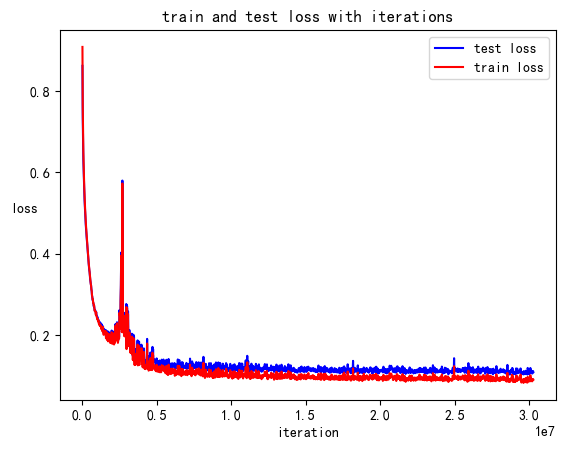

In [8]:
plt.plot(t_list, val_loss_list,color = 'b',label = 'test loss')
plt.plot(t_list, train_loss_list,color = 'r', label = 'train loss')
plt.title('train and test loss with iterations')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss',rotation='horizontal')
plt.show()

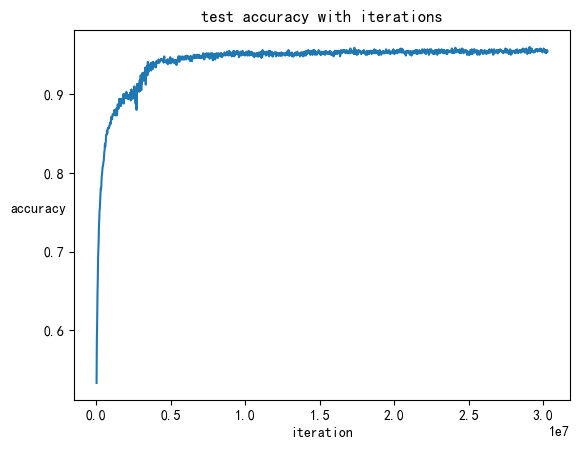

In [9]:
plt.plot(t_list, accuracy_list)
plt.title('test accuracy with iterations')
plt.xlabel('iteration')
plt.ylabel('accuracy',rotation='horizontal')
plt.show()

# 保存

In [10]:
np.savez('weights',w1_star,w2_star)

# 最优参数可视化

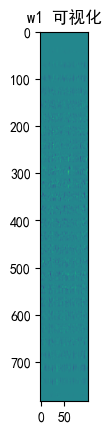

In [18]:
plt.imshow(w1_star)
plt.title('w1 可视化')
plt.show()

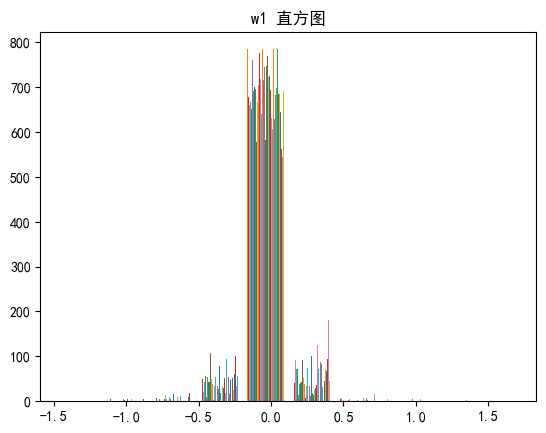

In [19]:
plt.hist(w1_star)
plt.title('w1 直方图')
plt.show()

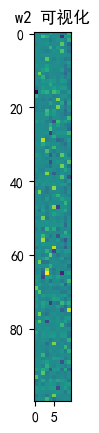

In [20]:
plt.imshow(w2_star)
plt.title('w2 可视化')
plt.show()

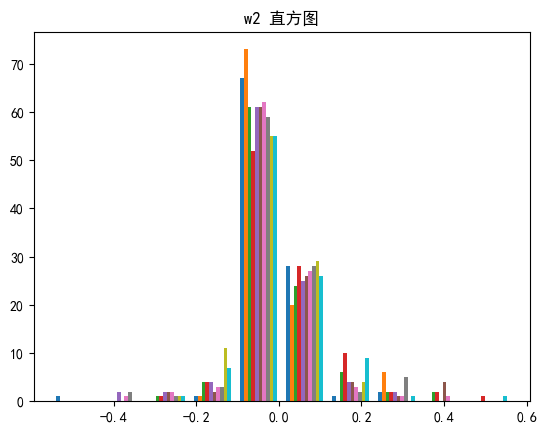

In [22]:
plt.hist(w2_star)
plt.title('w2 直方图')
plt.show()

# 读取

In [13]:
weights= np.load('weights.npz')
b1, b2 = weights['arr_0'], weights['arr_1']

# 预测准确率

In [ ]:
# def accuracy(ytrue, ypre):
#     ytrue = np.argmax(ytrue,1)
#     ypre = np.argmax(ypre,1)
#     compare = (ytrue == ypre)
#     return round(sum(compare)/len(compare),3)

In [14]:
# xtest2 = np.concatenate([xvalid,xtest],0)
# ytest2 = np.concatenate([yvalid,ytest],0)
ypre = predict(xtest, b1, b2)
print(accuracy(ytest, ypre))

0.956
